In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sun Aug 16 17:10:53 2020

@author: wanxiang.shen@u.nus.edu
"""

import warnings, os
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np
from glob import glob
from joblib import load, dump
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score
from sklearn.metrics import auc as calculate_auc

import matplotlib.pyplot as plt
import seaborn as sns

from aggmap import AggMap, AggModel, loadmap
from aggmap import show
np.random.seed(666) #just for reaptable results

import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5"

sns.set(style= 'white',font_scale = 1.2)

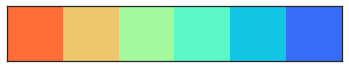

In [2]:
sns.set(style = 'white', font_scale=1.8)
colors = sns.color_palette("rainbow_r", 6) #PiYG
sns.palplot(colors)

In [3]:
flist = glob('./data/*.csv.gzip')
flist = pd.Series(flist).sort_values().tolist()
fall = []
for i in flist:
    df1 = pd.read_csv(i, compression='gzip', index_col = 0)
    df1['class'] = i.split('/')[-1].split('.csv')[0]
    fall.append(df1)
    
df = pd.concat(fall, axis=0)
dfx = df[df.columns[:-1]]
dfy = df[df.columns[-1:]]
dfx = np.log2(dfx + 1) #apply log2(x + 1)


In [4]:
data_save_folder = '/raid/shenwanxiang/transcriptome/pan-cancer'

X_noisys_5 = load(os.path.join(data_save_folder, 'Agg5_noisys.data')) 
X_noisys_1 = load(os.path.join(data_save_folder, 'Agg1_noisys.data')) 

In [5]:
dfy['idx'] = range(len(dfy))

In [6]:
Y = pd.get_dummies(dfy['class']).values

In [7]:
res5 = []

stddevs = np.arange(0, 0.5, 0.08)

for X, std in zip(X_noisys_5, stddevs):
    
    for i in range(10):

        fold_num = "fold_%s" % str(i).zfill(2) 
        save_path = './fold_results_c5/%s' % fold_num
        
        test_index = pd.read_csv(os.path.join(save_path, 'test_true_label.csv'), index_col=0).index
        test_idx = dfy[dfy.index.isin(test_index)]['idx'].tolist()
        train_idx = dfy[~dfy.index.isin(test_index)]['idx'].tolist()

        testY = Y[test_idx]
        testX = X[test_idx]

        trainX = X[train_idx]
        trainY = Y[train_idx]
        
        model = tf.keras.models.load_model(os.path.join(save_path, 'model.h5'))
        ls, acc = model.evaluate(testX, testY, verbose = 0)
        res5.append([std, fold_num, ls, acc])
    

In [8]:
df5 = pd.DataFrame(res5, columns=['std', 'fold_num', 'loss', 'acc'])

In [9]:
df5.groupby('std').mean()

,loss,acc
std,,
0.00,0.271844,0.963718
0.08,0.297380,0.959697
0.16,0.398204,0.941604
0.24,0.662055,0.899005
0.32,1.297693,0.813233
0.40,2.466809,0.683713
0.48,4.190309,0.535235


In [10]:
res1 = []

stddevs = np.arange(0, 0.5, 0.08)

for X, std in zip(X_noisys_1, stddevs):
    
    for i in range(10):

        fold_num = "fold_%s" % str(i).zfill(2) 
        save_path = './fold_results_c1/%s' % fold_num
        
        test_index = pd.read_csv(os.path.join(save_path, 'test_true_label.csv'), index_col=0).index
        test_idx = dfy[dfy.index.isin(test_index)]['idx'].tolist()
        train_idx = dfy[~dfy.index.isin(test_index)]['idx'].tolist()

        testY = Y[test_idx]
        testX = X[test_idx]

        trainX = X[train_idx]
        trainY = Y[train_idx]
        
        model = tf.keras.models.load_model(os.path.join(save_path, 'model.h5'))
        ls, acc = model.evaluate(testX, testY, verbose = 0)
        res1.append([std, fold_num, ls, acc])
    

In [11]:
df1 = pd.DataFrame(res1, columns=['std', 'fold_num', 'loss', 'acc'])

In [12]:
df1.groupby('std').mean()

,loss,acc
std,,
0.00,0.345708,0.954528
0.08,0.389219,0.946678
0.16,0.553538,0.920734
0.24,1.017946,0.848358
0.32,2.086169,0.717202
0.40,3.738115,0.553980
0.48,5.635121,0.413353


In [13]:
dfacc = df5.groupby('std').mean()['acc'].to_frame(name='C=5').join(df1.groupby('std').mean()['acc'].to_frame(name='C=1'))
dfacc.index = dfacc.index.map(lambda x: "%.2f" % x)

dfloss = df5.groupby('std').mean()['loss'].to_frame(name='C=5').join(df1.groupby('std').mean()['loss'].to_frame(name='C=1'))
dfloss.index = dfloss.index.map(lambda x: "%.2f" % x)

In [14]:
color = [colors[2], colors[1], ]

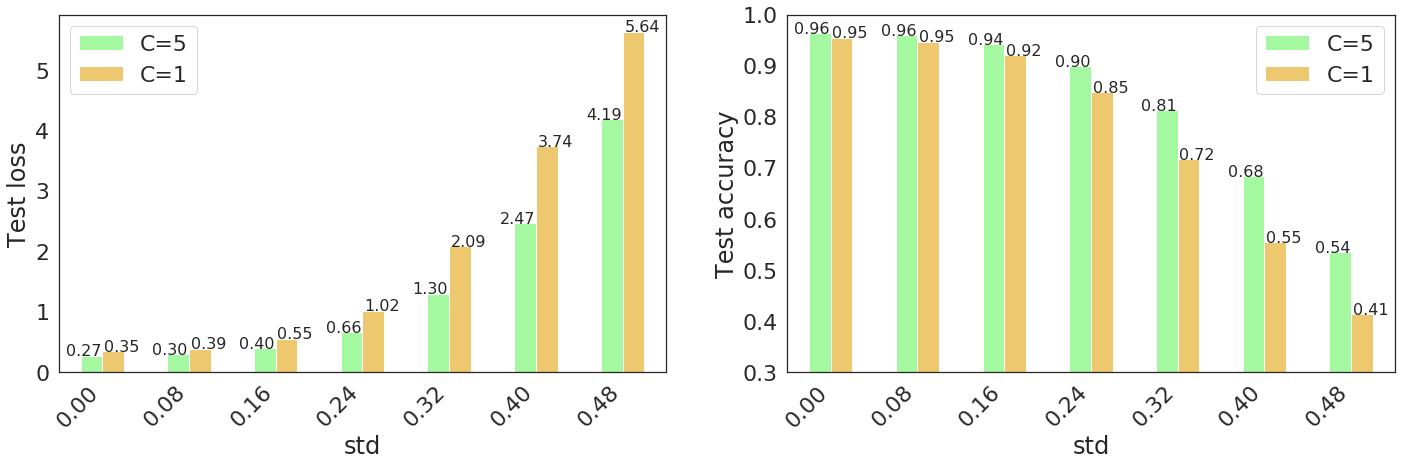

In [26]:
sns.set(style= 'white',font_scale = 2)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7), sharex=False, sharey=False, )
ax2, ax1 = axes        


#dfacc.plot(kind = 'line',  color = color, ax = ax1, legend = False)
dfacc.plot(kind = 'bar',  color = color, ax = ax1)

for x,y in enumerate(dfacc.index):
    for i, v in enumerate(dfacc.iloc[x].tolist()):
        s =  "%.2f" % v 
        if i == 1:
            ax1.text(x+0.02, v, s, fontsize= 16)
        else:
            ax1.text(x-0.42, v, s, fontsize= 16)
    
    
ax1.set_ylabel('Test accuracy')
ax1.set_xticklabels(labels = dfacc.index,rotation=45, ha = 'right')
ax1.set_ylim(0.3, 1)

#dfloss.plot(kind = 'line',  color = color, ax = ax2, legend = False)
dfloss.plot(kind = 'bar', color = color, ax = ax2)


for x,y in enumerate(dfloss.index):
    for i, v in enumerate(dfloss.iloc[x].tolist()):
        s =  "%.2f" % v 
        if i == 1:
            ax2.text(x+0.02, v, s, fontsize= 16)
        else:
            ax2.text(x-0.42, v, s, fontsize= 16)
    
# for x,y in enumerate(df2.values):
#     ax2.annotate('%.3f' % y, xy = (x-0.25, y+0.002))
ax2.set_ylabel('Test loss')
ax2.set_xticklabels(labels = dfloss.index,rotation=45, ha = 'right')

fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2)
#plt.savefig(os.path.join(results_save_folder, 'performance_Guassian_Noise_test.png'), bbox_inches='tight', dpi=400)

In [18]:
y

'0.48'

In [16]:
dfacc

,C=5,C=1
std,,
0.00,0.963718,0.954528
0.08,0.959697,0.946678
0.16,0.941604,0.920734
0.24,0.899005,0.848358
0.32,0.813233,0.717202
0.40,0.683713,0.553980
0.48,0.535235,0.413353


In [17]:
dfloss

,C=5,C=1
std,,
0.00,0.271844,0.345708
0.08,0.297380,0.389219
0.16,0.398204,0.553538
0.24,0.662055,1.017946
0.32,1.297693,2.086169
0.40,2.466809,3.738115
0.48,4.190309,5.635121
